In [1]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys

sys.path.append(os.path.abspath(os.path.join("../")))

In [2]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from numba import jit

import helper_libraries.results_tools as results_tools

# Load data

In [3]:
# Load data
forecast_oss_df, forecast_ins_df = results_tools.load_model_results(overnight=False, oos_periods=2, debug = True)
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

Loading the following model results...
--------------------------------------------------
Folder        No_overnight
Overnight            False
OOSPeriods               2
Predictors             All
--------------------------------------------------


# R-Squared

In [13]:
def compute_rsquared(truth, pred):
    return 1 - np.sum(np.square(truth-pred))/np.sum(np.square(truth))

In [46]:
# Get true values
forecast_oss_df["truth"] = fret_df["ff__mkt"]
forecast_ins_df["truth"] = fret_df["ff__mkt"]

# Set up dataframe with metrics
model_names = [
    x for x in ["_".join(col.split("_")[1:]) for col in forecast_oss_df.columns] if len(x) > 0
]
metrics_df = pd.DataFrame([], index=model_names)

# Fill in R2 estimates
for col in model_names:
    metrics_df.loc[col, "R2_ins"] = compute_rsquared(
        forecast_ins_df["truth"], forecast_ins_df["ins_" + col]
    )
    metrics_df.loc[col, "R2_oss"] = compute_rsquared(
        forecast_oss_df["truth"], forecast_oss_df["oss_" + col]
    )

metrics_df = metrics_df.applymap(lambda x: np.nan if np.abs(x) > 10 else x)
metrics_df["R2_diff"] = metrics_df["R2_oss"] - metrics_df["R2_ins"]

<AxesSubplot:>

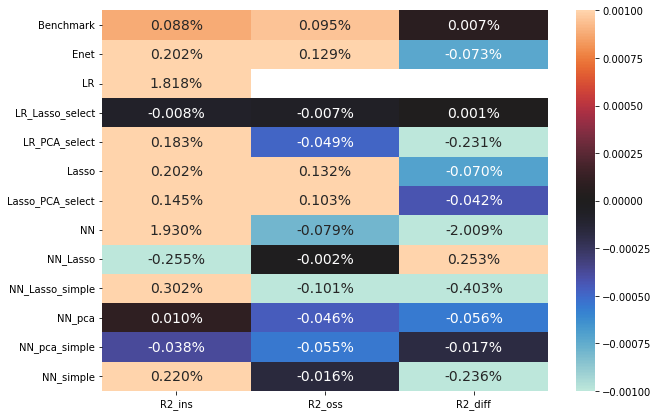

In [47]:
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(
    metrics_df,
    cmap="icefire",
    vmin=-0.1 / 100,
    center=0,
    vmax=0.1 / 100,
    annot=True,
    fmt=".3%",
    annot_kws={"fontsize": 14},
)

# Simulation

In [63]:
mkt_returns_oos_df = fret_df['ff__mkt']
mkt_returns_oos_intradaily_df = mkt_returns_oos_df.loc[
    mkt_returns_oos_df.index.time != dt.time(9, 30)
]
print(
    "Intradaily average return (annualized): ",
    mkt_returns_oos_intradaily_df.groupby(pd.Grouper(freq="1y")).sum().mean(),
)
print(
    "Intradaily average vol (annualized):    ",
    np.sqrt(
        mkt_returns_oos_intradaily_df.pipe(np.square).groupby(pd.Grouper(freq="1y")).sum()
    ).mean(),
)

Intradaily average return (annualized):  0.010678885864777596
Intradaily average vol (annualized):     0.1334104027402623


In [68]:
for delta_n, freq in zip(
    [1, 1 / 12, 1 / 12 / 21, 1 / 12 / 21 / 26], ["Annual", "Monthly", "Daily", "Intradaily"]
):

    print(f"[{freq}]")
    n = int(1e7)
    mean = delta_n * 0.010678885864777596 
    std = np.sqrt(delta_n) * 0.1334
    X = np.random.normal(mean, std, n)
    print(f"MonteCarlo: {1 - np.sum(np.square(X-mean)) / np.sum(np.square(X))}")
    print(f"Analytical: { 1 - std**2 / (mean**2 + std**2)}")
    print()

[Annual]
MonteCarlo: 0.006333741564785278
Analytical: 0.006367457241160612

[Monthly]
MonteCarlo: 0.0005236127145047398
Analytical: 0.0005337367706563789

[Daily]
MonteCarlo: 2.8982591822601655e-05
Analytical: 2.5428962767026775e-05

[Intradaily]
MonteCarlo: 9.241881750998715e-07
Analytical: 9.780609440124266e-07



In [69]:
# For all returns
for delta_n, freq in zip([1, 1/12, 1/12/21, 1/12/21/27], ['Annual', 'Monthly', 'Daily', 'Intradaily']):

    print(f'[{freq}]')
    n = int(1e7)
    mean = delta_n * 0.094
    std = np.sqrt(delta_n) * 0.166
    X = np.random.normal(mean, std, n)
    print(f'MonteCarlo: {1 - np.sum(np.square(X-mean)) / np.sum(np.square(X))}')
    print(f'Analytical: { 1 - std**2 / (mean**2 + std**2)}')
    print()

[Annual]
MonteCarlo: 0.24308621095887262
Analytical: 0.2428006155198945

[Monthly]
MonteCarlo: 0.026229077602697548
Analytical: 0.026025896296994477

[Daily]
MonteCarlo: 0.0013052277834214587
Analytical: 0.0012708278560402686

[Intradaily]
MonteCarlo: 4.305734059351085e-05
Analytical: 4.7125368520251065e-05

